In [1]:
import json
import pandas as pd
import numpy as np
import os
import ast
from pprint import pprint

import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
import scipy.stats as stats

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

In [2]:
order_text = ['Symbolicun+Unaligned', 'Symbolic+Aligned', 'Graphical+Aligned', 'Hybrid+Aligned']
abbr = ['SU', 'SA', 'GA', 'HA']
replace_dict = {order_text[i]: abbr[i] for i in range(4)}

In [3]:
replace_dict

{'Symbolicun+Unaligned': 'SU',
 'Symbolic+Aligned': 'SA',
 'Graphical+Aligned': 'GA',
 'Hybrid+Aligned': 'HA'}

# Read data 

In [4]:
# Each user id has 10 rows. 
# Each row presents the information about one question.
df_q = pd.read_csv(filepath_or_buffer='./reply_per_question.csv', sep=',', delimiter=None,)
df_q

,uid,cid,qid,acc,time,conf,acc/time,type
0,5f05056acc8d327f2948bbc0,SU,2,1,27.340,5,0.036576,1
1,5f05056acc8d327f2948bbc0,SU,3,1,19.176,5,0.052149,1
2,5f05056acc8d327f2948bbc0,SU,4,1,26.168,4,0.038215,1
3,5f05056acc8d327f2948bbc0,SU,5,1,38.567,4,0.025929,1
4,5f05056acc8d327f2948bbc0,SU,6,1,38.191,5,0.026184,1
...,...,...,...,...,...,...,...,...
3375,5f3f0641de4e871ea98cf4ee,HA,8,1,5.252,5,0.190404,2
3376,5f3f0641de4e871ea98cf4ee,HA,9,1,5.741,4,0.174186,2
3377,5f3f0641de4e871ea98cf4ee,HA,10,1,14.245,5,0.070200,2
3378,5f3f0641de4e871ea98cf4ee,HA,11,1,69.756,4,0.014336,2


In [5]:
# Each user id takes 2 rows.
# Each row shows the information about one task per user.
df_all = pd.read_csv(filepath_or_buffer='./overall_performance.csv', sep=',', delimiter=None,)
df_all

,uid,cid,acc,time,conf,type,acc/time
0,5f05056acc8d327f2948bbc0,SU,1.0,29.8884,4.6,1,0.033458
1,5f05056acc8d327f2948bbc0,SU,0.8,31.6494,4.2,2,0.025277
2,5e8fa4b58028052a7880c8ac,SU,1.0,46.3040,4.0,1,0.021596
3,5e8fa4b58028052a7880c8ac,SU,0.2,89.3016,4.0,2,0.002240
4,5c1d0cc2e2d9150001b599fa,SU,1.0,54.2506,4.0,1,0.018433
...,...,...,...,...,...,...,...
671,5edd5ca2fa8f13101b0b0e27,HA,1.0,34.7022,4.8,2,0.028817
672,5f0354704532c82550263e33,HA,1.0,17.1586,5.0,1,0.058280
673,5f0354704532c82550263e33,HA,1.0,28.2414,5.0,2,0.035409
674,5f3f0641de4e871ea98cf4ee,HA,1.0,12.8122,4.6,1,0.078051


In [6]:
# Each user id take 1 row
# Each row records one user's strategy and subjective sense of effort.
df_survey = pd.read_csv(filepath_or_buffer='./survey.csv', sep=',', delimiter=None,)
df_survey

,uid,cid,workload,strategy
0,5f05056acc8d327f2948bbc0,SU,2,I don't know what to say. I didn't use any par...
1,5e8fa4b58028052a7880c8ac,SU,4,Tried to focus on all the text. Text a bit sma...
2,5c1d0cc2e2d9150001b599fa,SU,2,I just counted how many times each of the opti...
3,5cff9c20c7ed63000188e9c5,SU,2,I just looked
4,5f2d4939e1b8742bba60a1e4,SU,2,combinations were hard but questions about one...
...,...,...,...,...
333,5e36fcbec0a4dc6800b82e28,HA,2,I learned from my mistake in the practice. I f...
334,5f4d0e546aa639969e6d8701,HA,1,i studied a module in AI as I do computer scie...
335,5edd5ca2fa8f13101b0b0e27,HA,2,i just took my time to work it out
336,5f0354704532c82550263e33,HA,1,Looked across the rows and followed them with ...


In [7]:
df_survey.groupby('cid').count()

,uid,workload,strategy
cid,,,
GA,81,81,81
HA,83,83,83
SA,88,88,88
SU,86,86,86


# Filter data

In [8]:
type1_df = df_all[df_all['type'] == 1]
type1_remove = type1_df[(type1_df['time'] < 5)| (type1_df['time'] > 100) | (type1_df['acc'] < .5) ]['uid']

In [9]:
type2_df = df_all[df_all['type'] == 2]
type2_remove = type2_df[(type2_df['time'] < 5) | (type2_df['time'] > 120) | (type2_df['acc'] < .5)]['uid']

In [10]:
to_remove = type1_remove.values.tolist()
to_remove.extend(type2_remove.values.tolist())
set(to_remove)

{'57441f8954636a000d7865ba',
 '580cab86b869700001d71628',
 '595ceea8dd044900012ce64a',
 '59966d059845ef00014de3d5',
 '5b9fec95c97c38000126d696',
 '5bdc8f69950dce0001bddd7e',
 '5c50efd2cc71f4000125ce0d',
 '5c6659863595be0001ade448',
 '5cac639638d61000014da640',
 '5cc48c234bb96d00018a8bfe',
 '5d0bae193e8262001589a71c',
 '5d3ee89122ed84000172272a',
 '5d758a3b5eeed2',
 '5e0fdde8b638537085d51b6c',
 '5e7dd5b90923ad0009f80bbc',
 '5e7f5cf737976e000850a4bb',
 '5e8fa4b58028052a7880c8ac',
 '5ea1f8de2ac60d0fbf1e5624',
 '5ebc59018442d1078efabe0b',
 '5ebf20dfbe8f9015d7928160',
 '5ec3f96a7bd12a09e859341b',
 '5edeea354d54cb1a825aa8f9',
 '5ee9fc83a17c1d02ad6c07e0',
 '5efe13f00c3da12c9d4fb635',
 '5eff6492814d8101d8ca4bcc',
 '5f1a2bdfdf6e2412308b8bab',
 '5f2175e522764352a52e1a55',
 '5f3139b4bae43925de65216a',
 '5f39806dc29bbc1014a85a72',
 '5f3e6c878e0c6807403c1941',
 '5f479b66ccae1c18c6c17105',
 '5f52585f5eceb74e35b1c704',
 '5f58e16e0fcd7108c2479e7c',
 '5f5a8366a5d808155508d64c',
 '5f5d31087a4abb5718b814

In [11]:
len(to_remove)

43

In [12]:
def get_cleaned_df(df, remove_idx):
    whole_new_list = []
    for i in df.index.values:
        if (df.iloc[i]['uid'] in remove_idx):
            continue
        whole_new_list.append(df.iloc[i])
    new_df = pd.DataFrame(columns=df.columns, data=whole_new_list)
    return new_df
    
df_all_clean = get_cleaned_df(df_all, to_remove)
df_q_clean = get_cleaned_df(df_q, to_remove)
df_survey_clean = get_cleaned_df(df_survey, to_remove)

In [13]:
df_survey_clean[['uid','cid']].groupby('cid').count()

,uid
cid,
GA,73
HA,78
SA,75
SU,77


In [14]:
def abs_es(ci, metric, task):
    if (task > 0):
        work_df = df_all_clean[df_all_clean['type']==task]
    else:
        work_df = df_survey_clean
    m1 = work_df[(work_df['cid']==ci)][metric].mean()    
    m2 = work_df[(work_df['cid']==abbr[0])][metric].mean()
    return m1-m2

In [15]:
for task in [1,2]:
    for metric in ['acc', 'time', 'conf']:
        print('-------------------------')
        for ci in abbr[1:]:
            print(task, ci, abs_es(ci, metric, task))

-------------------------
1 SA 0.02528138528138535
1 GA 0.016331613591887617
1 HA 0.02374292374292375
-------------------------
1 SA -18.40369838961039
1 GA -19.35012545810354
1 HA -18.626666799866797
-------------------------
1 SA 0.2525367965367966
1 GA 0.21206191069204738
1 HA 0.18115218115218124
-------------------------
2 SA -0.0002424242424242662
2 GA -0.022415940224159492
2 HA -0.016550116550116623
-------------------------
2 SA -7.442233593073595
2 GA -11.488085465219712
2 HA -9.8966376956377
-------------------------
2 SA 0.11802597402597303
2 GA 0.04799857676569985
2 HA -0.08494838494838453


# Visualization

In [16]:
# calculate CI for contrast
def generate_df_diff(df, key):
#     val1 = df[df['cid'] == order_text[0]][key].values
#     val2 = df[df['cid'] == order_text[1]][key].values
#     val3 = df[df['cid'] == order_text[2]][key].values
#     val4 = df[df['cid'] == order_text[3]][key].values
    val1 = df[df['cid'] == abbr[0]][key].values
    val2 = df[df['cid'] == abbr[1]][key].values
    val3 = df[df['cid'] == abbr[2]][key].values
    val4 = df[df['cid'] == abbr[3]][key].values

    # compare with 1
    val2_diff = [a-b for a in val2 for b in val1]
    val3_diff = [a-b for a in val3 for b in val1]
    val4_diff = [a-b for a in val4 for b in val1]

#     compared = [order_text[1]] * len(val2_diff)
#     compared.extend([order_text[2]] * len(val3_diff))
#     compared.extend([order_text[3]] * len(val4_diff))
    compared = [abbr[1]] * len(val2_diff)
    compared.extend([abbr[2]] * len(val3_diff))
    compared.extend([abbr[3]] * len(val4_diff))
    val_diff = np.array(val2_diff)
    val_diff = np.append(val_diff, np.array(val3_diff))
    val_diff = np.append(val_diff, np.array(val4_diff))

    df_diff = pd.DataFrame()
    df_diff['compared'] = compared
    df_diff['contrast'] = val_diff
    return df_diff, val_diff

In [17]:
# print(bs.bootstrap(np.array(val_diff), stat_func=bs_stats.mean))

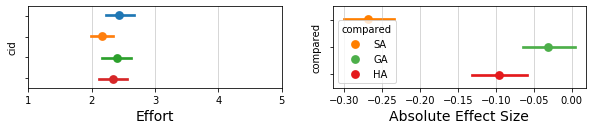

In [18]:
# overall workload
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,1.5))

ax = axes[0]
ax.set_xlabel("",fontsize=14)
sns.pointplot(y="cid", x='workload', data=df_survey_clean, estimator=np.mean, dodge=True, hue="cid",
               join=False,ax=ax).set( xticks=[1,2,3,4,5], yticklabels=[], xlabel='Effort')
ax.get_legend().remove()
# ax.grid()
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True, linewidth=0.5) # Show the vertical gridlines

ax = axes[1]
df_work_diff, val_diff =  generate_df_diff(df_survey_clean, 'workload')

ax.set_xlabel("",fontsize=14)
sns.pointplot(x="contrast", y='compared', data=df_work_diff, ax=ax,
              palette=['#ff7f00','#4daf4a', '#e41a1c', ], hue='compared', 
              estimator=np.mean, dodge=True, join=False).set( yticklabels=[], 
#                                                              xticks=[0,.1,.2,.3,.4, .5, .6, .7, .8, .9],
                                                             xlabel='Absolute Effect Size',
                                                            )
# ax.get_legend().remove()
# ax.grid()
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True,linewidth=0.5) # Show the vertical gridlines


fig.savefig('workload.png', bbox_inches='tight')


In [19]:
# effect size of work load
for ci in abbr[1:]:
    print(ci, abs_es(ci, 'workload', -1))

SA -0.26857142857142824
GA -0.03131115459882583
HA -0.0952380952380949


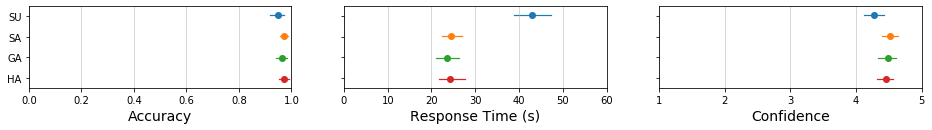

In [20]:
# type 1
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,1.5))
type1_df = df_all_clean[df_all_clean['type'] == 1]

ax = axes[0]
# ax.set_xticklabels(labels, rotation=45)
ax.set_xlabel("",fontsize=14)
sns.pointplot(y="cid", x='acc', data=type1_df, estimator=np.mean, dodge=True,scale=0.8,errwidth=1.2,
              hue="cid", join=False, ax=ax).set( xticks=[0,.2,.4,.6,.8,1], xlabel='Accuracy', ylabel='')
# ax.grid()
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True,linewidth=0.5) # Show the vertical gridlines
ax.get_legend().remove()

# ax.legend().set_title('')
# plt.setp(ax.get_legend().get_texts(), fontsize='8',) # for legend text

ax = axes[1]
# ax.set_xticklabels(labels, rotation=45)
ax.set_xlabel("",fontsize=14)
sns.pointplot(y="cid", x='time', data=type1_df, estimator=np.mean, dodge=True,scale=0.8,errwidth=1.2,
              hue="cid", join=False, ax=ax).set( xticks=range(0, 70, 10), yticklabels=[],xlabel='Response Time (s)', ylabel='')
ax.get_legend().remove()
# ax.grid()
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True,linewidth=0.5) # Show the vertical gridlines

ax = axes[2]
# ax.set_xticklabels(labels, rotation=45)
ax.set_xlabel("",fontsize=14)
sns.pointplot(y="cid", x='conf', data=type1_df, estimator=np.mean, dodge=True,scale=0.8,errwidth=1.2,
              hue="cid", join=False, ax=ax).set( xticks=[1,2,3,4,5], yticklabels=[], xlabel='Confidence', ylabel='')
ax.get_legend().remove()
# ax.grid()
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True,linewidth=0.5) # Show the vertical gridlines
# ax = axes[3]
# ax.set_xticklabels(labels, rotation=45)
# sns.pointplot(x="cid", y='acc/time', data=type1_df, estimator=np.mean, dodge=True,
#               hue="cid", join=False, ax=ax).set( yticks=[0.,0.01,0.02,0.03,.04,.05])
# ax.get_legend().remove()


fig.savefig('task1.pdf', bbox_inches='tight')

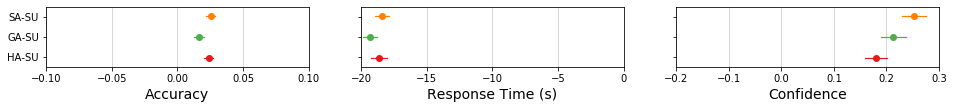

In [21]:
# task 1 contrast
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,1.1))
type1_df = df_all_clean[df_all_clean['type'] == 1]

ax = axes[0]
ax.set_xlabel("",fontsize=14)
df_diff, val_diff = generate_df_diff(type1_df,'acc')
sns.pointplot(x="contrast", y='compared', data=df_diff, ax=ax, palette=['#ff7f00','#4daf4a', '#e41a1c', ],
              scale=0.8,errwidth=1.2, 
              hue='compared', estimator=np.mean, dodge=True, join=False).set( 
    yticklabels=['SA-SU', 'GA-SU', 'HA-SU'],
    xticks=[-0.1,-.05, 0,.05,.1,], xlabel='Accuracy', ylabel='')
ax.get_legend().remove()
# ax.grid()
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True,linewidth=0.5) # Show the vertical gridlines

ax = axes[1]
ax.set_xlabel("",fontsize=14)
df_diff, val_diff  = generate_df_diff(type1_df,'time')
sns.pointplot(x="contrast", y='compared', data=df_diff, ax=ax, palette=['#ff7f00','#4daf4a', '#e41a1c', ],
               scale=0.8,errwidth=1.2,hue='compared',estimator=np.mean, dodge=True, join=False).set( 
    xticks=[-20, -15, -10, -5, 0], yticklabels=[], xlabel='Response Time (s)', ylabel='')
ax.get_legend().remove()
# ax.grid()
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True,linewidth=0.5) # Show the vertical gridlines

ax = axes[2]
ax.set_xlabel("",fontsize=14)
df_diff, val_diff  = generate_df_diff(type1_df,'conf')
sns.pointplot(x="contrast", y='compared', data=df_diff, ax=ax, palette=['#ff7f00','#4daf4a', '#e41a1c', ],
               scale=0.8,errwidth=1.2, hue='compared',estimator=np.mean, dodge=True, join=False).set( 
    xticks=[-.2,-.1, 0,.1,.2,.3], yticklabels=[], xlabel='Confidence', ylabel='')
ax.get_legend().remove()
# ax.grid()
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True,linewidth=0.5) # Show the vertical gridlines
# ax = axes[3]
# ax.set_xticklabels(labels, rotation=45)
# sns.pointplot(x="cid", y='acc/time', data=type1_df, estimator=np.mean, dodge=True,
#               hue="cid", join=False, ax=ax).set( yticks=[0.,0.01,0.02,0.03,.04,.05])
# ax.get_legend().remove()

fig.savefig('task1_contrast.pdf', bbox_inches='tight')


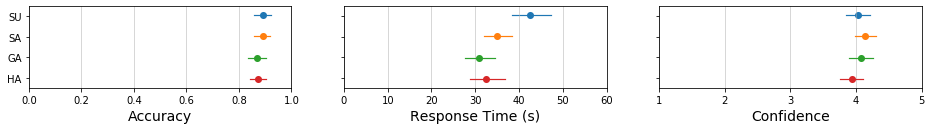

In [24]:
# type 2
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,1.5))
type2_df = df_all_clean[df_all_clean['type'] == 2]

ax = axes[0]
# ax.set_xticklabels(labels, rotation=45)
ax.set_xlabel("",fontsize=14)
sns.pointplot(y="cid", x='acc', data=type2_df, estimator=np.mean, dodge=True,scale=0.8,errwidth=1.2,
              hue="cid", join=False, ax=ax).set(xticks=[0,.2,.4,.6,.8,1], xlabel='Accuracy', ylabel='')
ax.legend().set_title('condition')
ax.get_legend().remove()

# ax.grid()
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True,linewidth=0.5) # Show the vertical gridlines
# ax._legend.set_title("Condition")

ax = axes[1]
ax.set_xlabel("",fontsize=14)
# ax.set_xticklabels(labels, rotation=45)
sns.pointplot(y="cid", x='time', data=type2_df, estimator=np.mean, dodge=True,scale=0.8,errwidth=1.2,
              hue="cid", join=False, ax=ax).set( xticks=range(0, 70, 10), yticklabels=[],xlabel='Response Time (s)', ylabel='')
ax.get_legend().remove()
# ax.grid()
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True,linewidth=0.5) # Show the vertical gridlines

ax = axes[2]
ax.set_xlabel("",fontsize=14)
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True,linewidth=0.5) # Show the vertical gridlines
# ax.set_xticklabels(labels, rotation=45)
sns.pointplot(y="cid", x='conf', data=type2_df, estimator=np.mean, dodge=True,scale=0.8,errwidth=1.2,
              hue="cid", join=False, ax=ax).set( xticks=[1,2,3,4,5], yticklabels=[], xlabel='Confidence', ylabel='')
ax.get_legend().remove()
# ax.grid()
# ax = axes[3]
# ax.set_xticklabels(labels, rotation=45)
# sns.pointplot(x="cid", y='acc/time', data=type1_df, estimator=np.mean, dodge=True,
#               hue="cid", join=False, ax=ax).set( yticks=[0.,0.01,0.02,0.03,.04,.05])
# ax.get_legend().remove()

fig.savefig('task2.pdf', bbox_inches='tight')

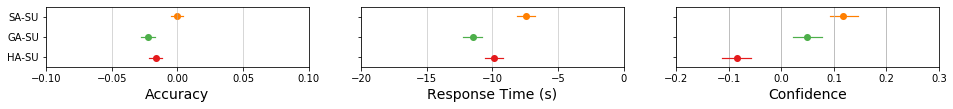

In [25]:
# task 2 contrast
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,1.1))
type2_df = df_all_clean[df_all_clean['type'] == 2]

ax = axes[0]
ax.set_xlabel("",fontsize=14)
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True,linewidth=0.5) # Show the vertical gridlines
df_diff, val_diff = generate_df_diff(type2_df, 'acc')
sns.pointplot(x="contrast", y='compared', data=df_diff, ax=ax, palette=['#ff7f00','#4daf4a', '#e41a1c', ]
              ,scale=0.8,errwidth=1.2,
              hue='compared', estimator=np.mean, dodge=True, join=False).set( 
        yticklabels=['SA-SU', 'GA-SU', 'HA-SU'],xticks=[-0.1,-0.05, 0, 0.05,0.1], xlabel='Accuracy', ylabel='')
# ax.grid()
ax.get_legend().remove()


ax = axes[1]
ax.set_xlabel("",fontsize=14)
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True,linewidth=0.5) # Show the vertical gridlines
df_diff, val_diff = generate_df_diff(type2_df,'time')
sns.pointplot(x="contrast", y='compared', data=df_diff, ax=ax, palette=['#ff7f00','#4daf4a', '#e41a1c', ]
              ,scale=0.8,errwidth=1.2,
               hue='compared',estimator=np.mean, dodge=True, join=False).set( 
    xticks=[-20, -15, -10, -5, 0], yticklabels=[], xlabel='Response Time (s)', ylabel='')
# ax.grid()
ax.get_legend().remove()


ax = axes[2]
ax.set_xlabel("",fontsize=14)
ax.yaxis.grid(False) # Hide the horizontal gridlines
ax.xaxis.grid(True,linewidth=0.8) # Show the vertical gridlines
df_diff, val_diff = generate_df_diff(type2_df,'conf')
sns.pointplot(x="contrast", y='compared', data=df_diff, ax=ax, palette=['#ff7f00','#4daf4a', '#e41a1c', ]
              ,scale=0.8,errwidth=1.2,
               hue='compared',estimator=np.mean, dodge=True, join=False).set( 
    xticks=[-.2,-.1,0,.1,.2,.3], yticklabels=[], xlabel='Confidence', ylabel='')
# ax.grid()

ax.get_legend().remove()

# ax = axes[3]
# ax.set_xticklabels(labels, rotation=45)
# sns.pointplot(x="cid", y='acc/time', data=type1_df, estimator=np.mean, dodge=True,
#               hue="cid", join=False, ax=ax).set( yticks=[0.,0.01,0.02,0.03,.04,.05])
# ax.get_legend().remove()

fig.savefig('task2_contrast.pdf', bbox_inches='tight')
